# LOFAR log-scale

In [1]:
from lofarantpos.db import LofarAntennaDatabase

In [2]:
import json

In [3]:
import numpy as np

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
np.set_printoptions(suppress=True)

In [6]:
db = LofarAntennaDatabase()

In [7]:
import lofarantpos.geo as lofargeo

In [8]:
field_coords = {
    station: lofargeo.transform(
        [db.phase_centres[station]],
        db.phase_centres["CS002LBA"],
        db.pqr_to_etrs["CS002LBA"].T,
    )
    for station in db.phase_centres
    if "LBA" in station
}

In [9]:
import matplotlib.pyplot as plt

In [10]:
from numpy.linalg import norm

In [11]:
for name in field_coords:
    print(
        name,
        f"{field_coords[name][0, 0]:10.2f}  ",
        f"{field_coords[name][0, 1]:10.2f}  ",
        f"{field_coords[name][0, 2]:8.2f}",
    )

CS001LBA    -148.18      -414.48       0.85
CS002LBA       0.00         0.00       0.00
CS003LBA     -85.00        89.00       0.00
CS004LBA     -92.00       -83.50       0.00
CS005LBA      35.30      -121.10      -0.00
CS006LBA     119.00       -42.80      -0.00
CS007LBA      80.70        43.00       0.00
CS011LBA     250.25      -151.36       0.10
CS013LBA    -201.57       322.02       0.19
CS017LBA     489.32        71.34       0.00
CS021LBA    -460.47       285.04       0.25
CS024LBA     313.81      -784.01       1.34
CS026LBA     863.09       104.68      -0.04
CS028LBA     352.76      1179.88      -0.04
CS030LBA    -563.67       795.56      -0.28
CS031LBA    -727.34       283.04       0.17
CS032LBA    -668.10      -295.52       0.94
CS101LBA     764.42       811.06      -0.59
CS103LBA    1819.85        69.32      -0.40
RS106LBA    7759.79     -4564.30      -3.89
CS201LBA     868.63      -297.35       0.44
RS205LBA    1813.64     -6412.58      -0.12
RS208LBA    3324.45    -27351.41

In [12]:
def mylog(a):
    with np.errstate(divide="ignore"):
        a = np.where(a > 0, np.sqrt(np.abs(a)), a)
        a = np.where(a < 0, -np.sqrt(np.abs(-a)), a)
        return a

In [13]:
def trans(x, y):
    x = np.array(x)
    y = np.array(y)
    return mylog(x), mylog(y)

In [14]:
def trans(x, y):
    pw = 0.4
    x = np.array(x)
    y = np.array(y)
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return rho**pw * np.cos(phi), rho**pw * np.sin(phi)

In [15]:
import shapely
from shapely.geometry import GeometryCollection, shape

In [18]:
with open("europe.geojson") as f:
    features = json.load(f)["features"]
countries = [
    shape(feature["geometry"]).buffer(0)
    for feature in features
    if feature["properties"]["ISO2"] != "NL"
]
isocodes = [
    feature["properties"]["ISO2"]
    for feature in features
    if feature["properties"]["ISO2"] != "NL"
]

In [19]:
with open("africa.geojson") as f:
    features = json.load(f)["features"]
africa = [shape(feature["geometry"]).buffer(0) for feature in features]

In [22]:
with open("provincies-cbs.geojson") as f:
    features = json.load(f)["features"]
provinces = [shape(feature["geometry"]).buffer(0) for feature in features]

In [23]:
def polygon_or_multipolygon(p):
    if p.geometryType() == "MultiPolygon":
        return p.geoms
    else:
        return [p]

In [24]:
lofarcountries = ["IE", "GB", "DE", "NL", "FR", "IE", "IT", "FR", "SE", "PL", "LV", "BG"]

In [25]:
def getcolor(isocode):
    if isocode in lofarcountries:
        return "#004b93"
    else:
        return "#d9d9d9"

In [26]:
mylog(-np.array([field_coords[name][0, 2] for name in field_coords]))

array([ -0.91927292,  -0.        ,  -0.01038517,  -0.01069097,
         0.01685747,   0.00610699,  -0.01430337,  -0.3172588 ,
        -0.43998715,  -0.06939825,  -0.49642061,  -1.15638028,
         0.20412705,   0.19731741,   0.5285216 ,  -0.41103646,
        -0.97089449,   0.76955388,   0.63370099,   1.9716856 ,
        -0.65991317,   0.34260522,   7.13711557,  17.62135319,
        -1.1835187 ,  -3.2826234 ,  -1.6077655 ,  -1.01908466,
         3.74731342,  14.70533529,  -1.32300952,   2.37999182,
         6.46868954,   9.75757231,   0.62371116,   1.85625446,
        10.95501901,  15.90272956,  72.2189055 , 161.25662397,
       109.3545499 , 117.09711296,  62.55138573, 195.53729683,
       166.39675417, 168.0066724 ,  62.71600956, 194.03762992,
       279.1663478 , 256.20649602, 276.87698197, 302.30281247])

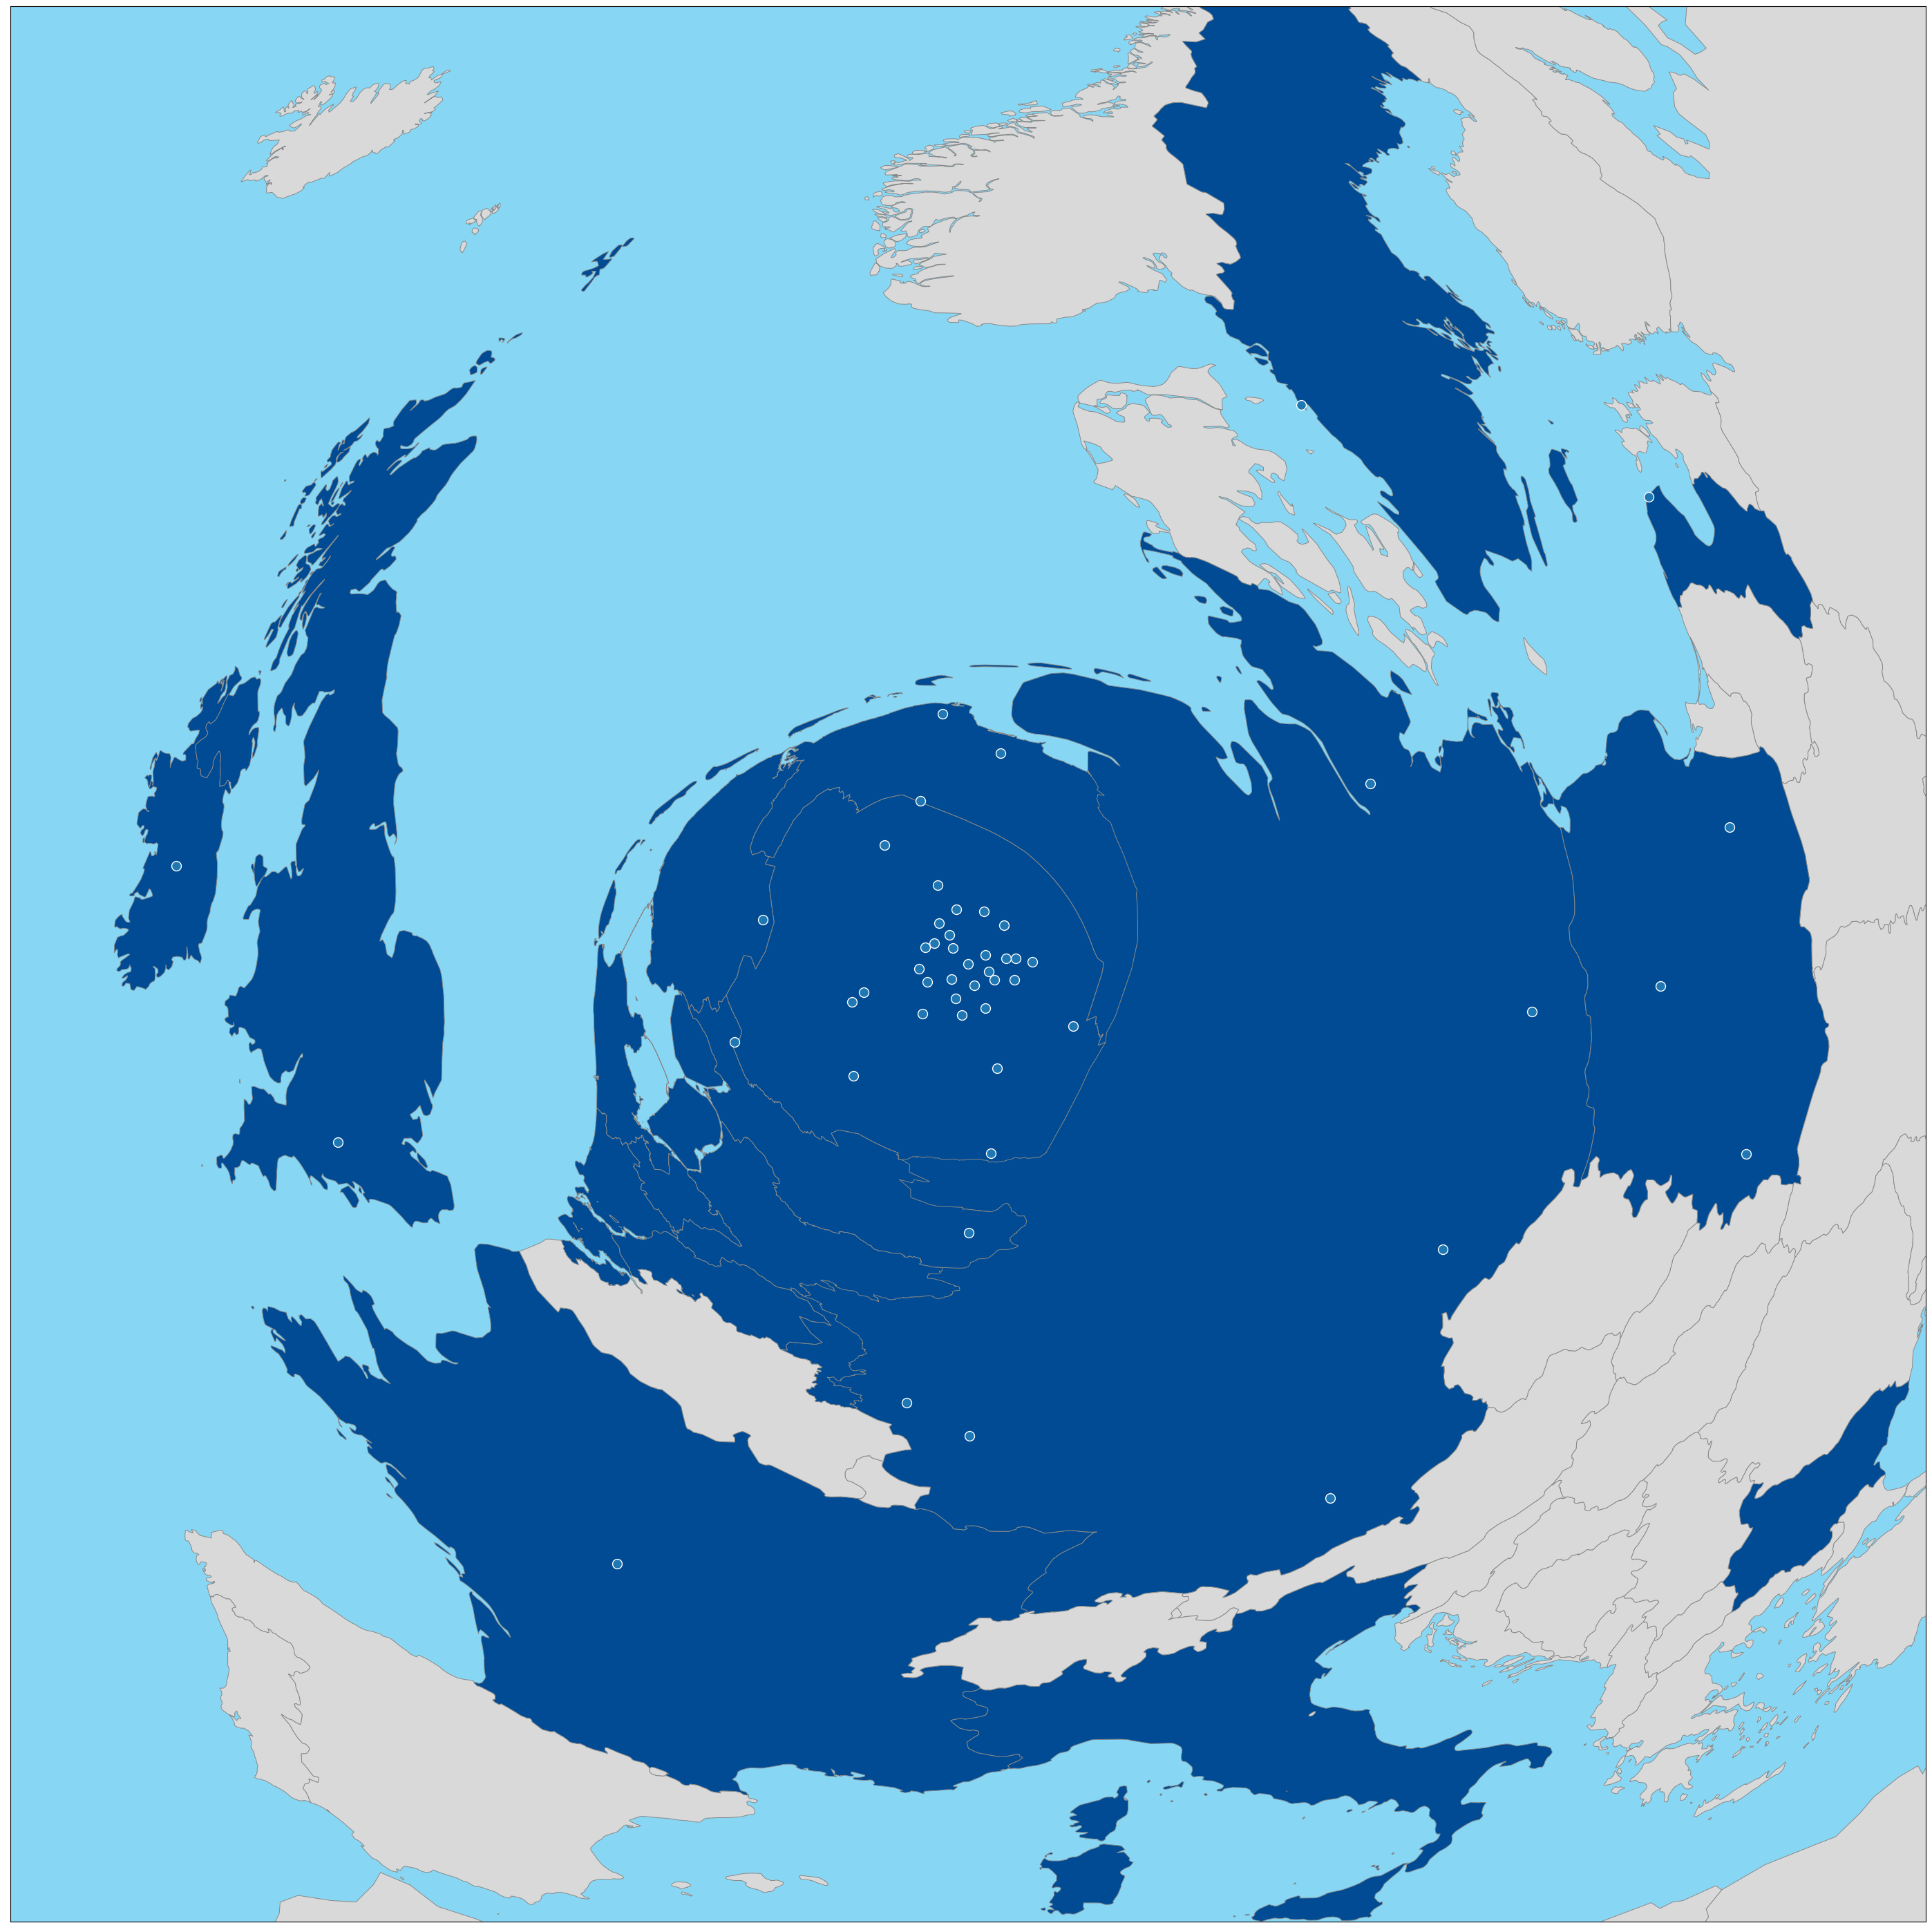

In [29]:
fig, ax = plt.subplots(figsize=(16 * 4, 9 * 4))
for isocode, country in zip(isocodes, countries):
    for polygon in polygon_or_multipolygon(country):
        lon, lat = polygon.exterior.xy
        xyz = lofargeo.xyz_from_geographic(np.deg2rad(lon), np.deg2rad(lat), 0)
        pqr = lofargeo.transform(
            xyz.T, db.phase_centres["CS002LBA"], db.pqr_to_etrs["CS002LBA"].T
        )
        ax.fill(*trans(pqr[:, 0], pqr[:, 1]), getcolor(isocode), zorder=1)
        ax.plot(*trans(pqr[:, 0], pqr[:, 1]), "#888888", linewidth=0.7, zorder=1)
for country in africa:
    for polygon in polygon_or_multipolygon(country):
        lon, lat = polygon.exterior.xy
        xyz = lofargeo.xyz_from_geographic(np.deg2rad(lon), np.deg2rad(lat), 0)
        pqr = lofargeo.transform(
            xyz.T, db.phase_centres["CS002LBA"], db.pqr_to_etrs["CS002LBA"].T
        )
        ax.fill(*trans(pqr[:, 0], pqr[:, 1]), getcolor(isocode), zorder=1)
        ax.plot(*trans(pqr[:, 0], pqr[:, 1]), "#888888", linewidth=0.7, zorder=1)
for province in provinces:
    for polygon in polygon_or_multipolygon(province):
        lon, lat = polygon.exterior.xy
        xyz = lofargeo.xyz_from_geographic(np.deg2rad(lon), np.deg2rad(lat), 0)
        pqr = lofargeo.transform(
            xyz.T, db.phase_centres["CS002LBA"], db.pqr_to_etrs["CS002LBA"].T
        )
        ax.fill(*trans(pqr[:, 0], pqr[:, 1]), "#004b93", zorder=2)
        ax.plot(*trans(pqr[:, 0], pqr[:, 1]), "#888888", linewidth=0.7, zorder=2)
ax.plot(
    *trans(
        [field_coords[name][0, 0] for name in field_coords],
        [field_coords[name][0, 1] for name in field_coords],
    ), 'o', markersize=10,
    #c='#f8b133',
    zorder=3, markeredgecolor='white',
    #c=[[1,0,0]]*len(field_coords)#
    #c=mylog(-np.array([field_coords[name][0, 2] for name in field_coords])), vmax=20
)
ax.set_facecolor("#87d7f4")
ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([]);
fig.savefig("lofar-scale.png")